In [278]:
import pandas as pd

# Load the initial dataset
file_path = 'final_dataset.csv'
df = pd.read_csv(file_path)
#df['Job'] = df['Job'].replace('Statistician', 'Research Scientist')

In [279]:
df.Job.value_counts()

Data Scientist               6530
Software Engineer            3424
DataAnalyst                  3143
Research Scientist           2429
Machine Learning Engineer    2398
Name: Job, dtype: int64

In [280]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

data = df.copy()
# Sample categorical and numerical features
categorical_features = ['Education', 'Language', 'IDE', 'Course_platform', 'ML_algorithm', 'Related_activities']  
numerical_features = ['Age', 'Years_of_programming', 'Years_of_machine_learning', 'Company_size', 'Yearly_compensation']  

# One-Hot Encoding for Multi-Answer Categorical Features
mlb = MultiLabelBinarizer()
for feature in categorical_features:
    # Splitting each feature into a list of items
    data[feature] = data[feature].str.split(', ').apply(lambda x: [item.strip() for item in x])
    # Applying MultiLabelBinarizer
    encoded_features = pd.DataFrame(mlb.fit_transform(data[feature]), columns=mlb.classes_)
    # Drop the original column and add the encoded columns
    data = data.drop(columns=[feature])
    data = pd.concat([data, encoded_features], axis=1)

# Normalize Numerical Features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [281]:
#data.to_csv('dataset.csv', index=False)
data = data.drop('Other', axis=1)
data = data.loc[:, ~data.columns.duplicated()]
data = data.drop(columns=['analyzing', 'and operationalizing data'])
#duplicate_columns = data.columns.duplicated()
#duplicate_column_names = data.columns[duplicate_columns].tolist()
#data=data.drop(columns=duplicate_column_names)
data.columns

Index(['Age', 'Job', 'Years_of_programming', 'Years_of_machine_learning',
       'Company_size', 'Yearly_compensation', 'Bachelor’s degree',
       'Doctoral degree', 'Master’s degree',
       'No formal education past high school', 'Professional degree',
       'Professional doctorate',
       'Some college/university study without earning a bachelor’s degree',
       'Bash', 'C', 'C#', 'C++', 'Go', 'Java', 'Javascript', 'Julia', 'MATLAB',
       'None', 'PHP', 'Python', 'R', 'SQL', 'Swift', 'IntelliJ', 'Jupyter',
       'Notepad++', 'PyCharm', 'RStudio', 'Spyder', 'Sublime Text',
       'Vim / Emacs', 'Visual Studio', 'Visual Studio Code',
       'Cloud-certification programs', 'Coursera', 'DataCamp', 'Fast.ai',
       'Kaggle Learn Courses', 'LinkedIn Learning', 'Udacity', 'Udemy',
       'University Courses', 'edX', 'Autoencoder Networks',
       'Bayesian Approaches', 'Convolutional Neural Networks',
       'Decision Trees or Random Forests', 'Dense Neural Networks',
       'Evolu

In [282]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Job'] = label_encoder.fit_transform(data['Job'])
# Splitting the Dataset
X = data.drop(columns=['Job'])  
y = data['Job']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

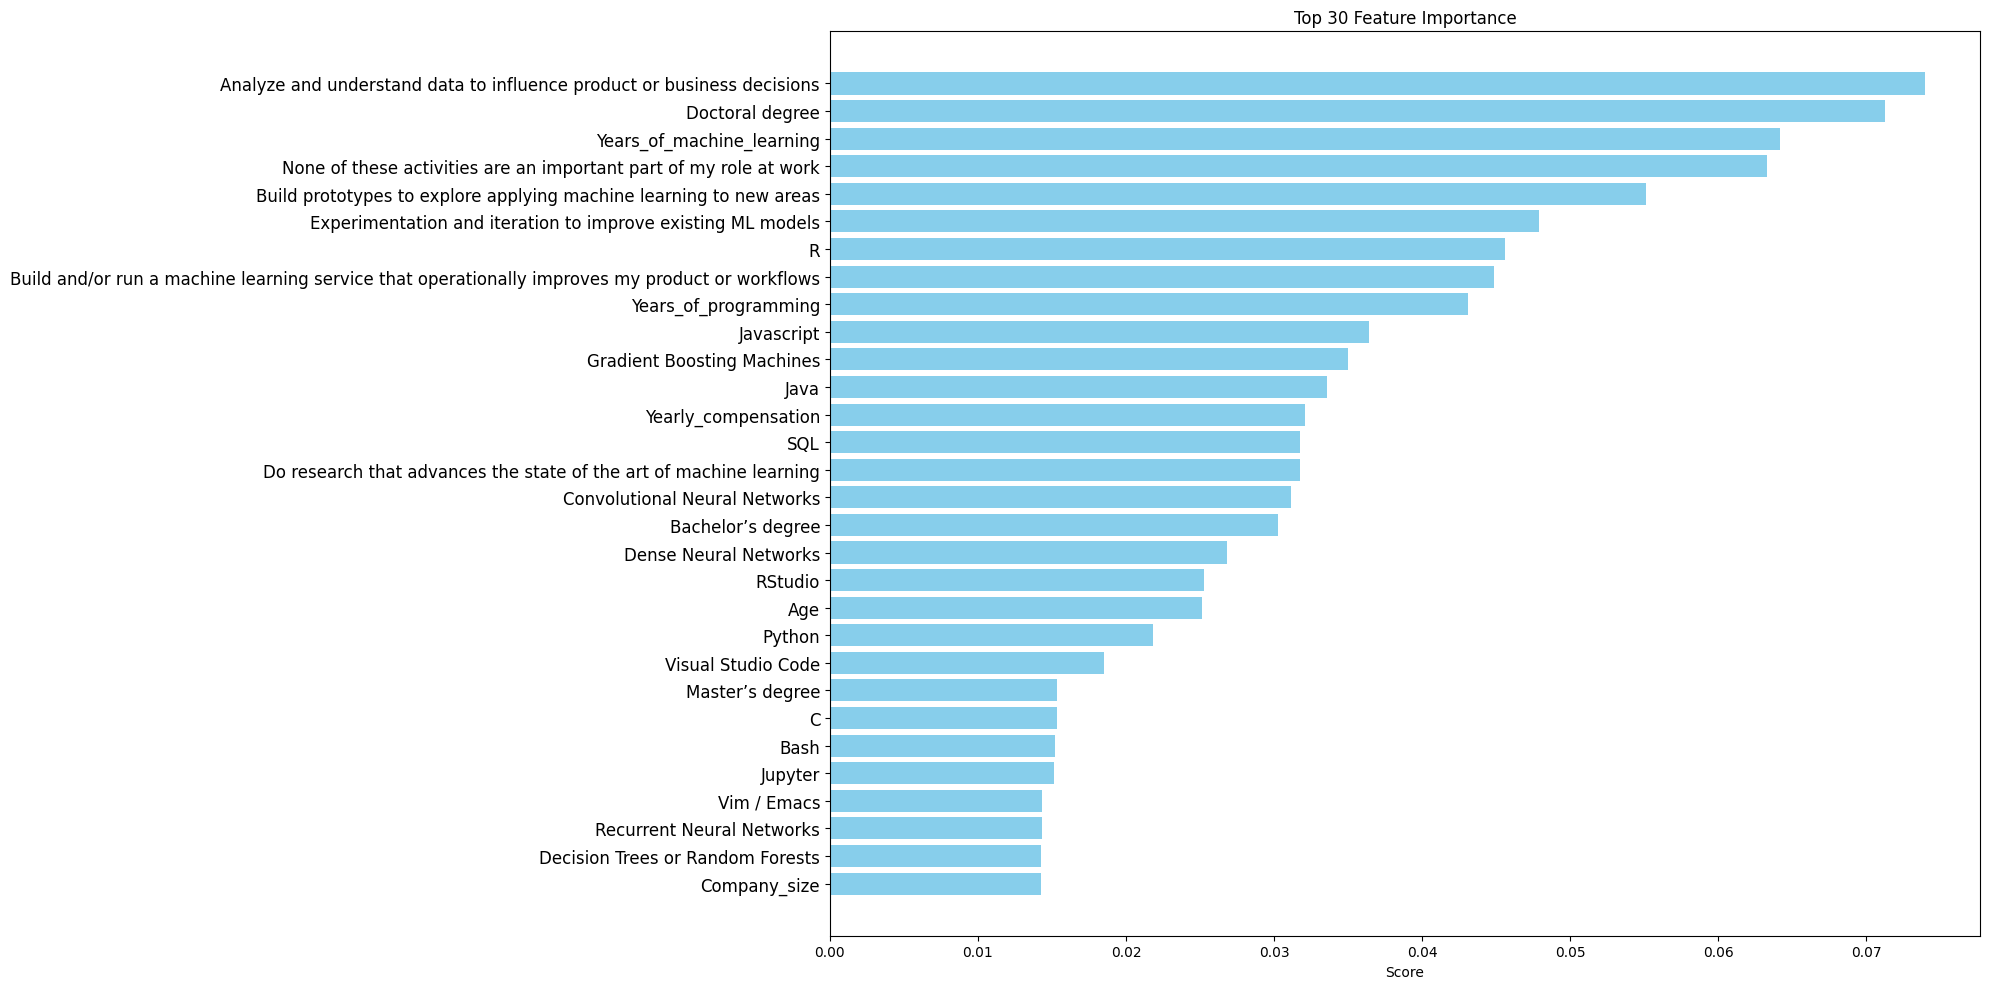

In [283]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
import matplotlib.pyplot as plt
skb = SelectKBest(mutual_info_classif, k=54)  # Select top features
skb.fit(X_train, y_train)

# Creating DataFrame of feature scores
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': skb.scores_
})

# Sorting the DataFrame based on scores and selecting top 100
feature_scores_sorted = feature_scores.sort_values(by='Score', ascending=False).head(30)

# Plotting
plt.figure(figsize=(20, 10)) 
plt.barh(feature_scores_sorted['Feature'], feature_scores_sorted['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Top 30 Feature Importance')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [284]:
import numpy as np
#select the 100 most important features
X_train_sel=X_train[X_train.columns[skb.scores_ >= np.sort(skb.scores_)[-54]]]
X_test_sel =X_test[X_test.columns[skb.scores_ >= np.sort(skb.scores_)[-54]]]

In [285]:
# Model Training
model = RandomForestClassifier(max_depth= 20, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 150, random_state=42)
model.fit(X_train_sel, y_train)

# Model Evaluation
y_pred_rf = model.predict(X_test_sel)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# 获Obtaining reverse mapping label
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Using reverse mapping to obtain the class name
y_true_names = [reverse_label_mapping[i] for i in y_test]
y_pred_names = [reverse_label_mapping[i] for i in y_pred_rf]

# Print evaluation report
report = classification_report(y_true_names, y_pred_names)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.5737796373779638
                           precision    recall  f1-score   support

           Data Scientist       0.56      0.74      0.64      1340
              DataAnalyst       0.52      0.49      0.50       597
Machine Learning Engineer       0.46      0.20      0.28       459
       Research Scientist       0.62      0.48      0.54       507
        Software Engineer       0.65      0.64      0.65       682

                 accuracy                           0.57      3585
                macro avg       0.56      0.51      0.52      3585
             weighted avg       0.57      0.57      0.56      3585



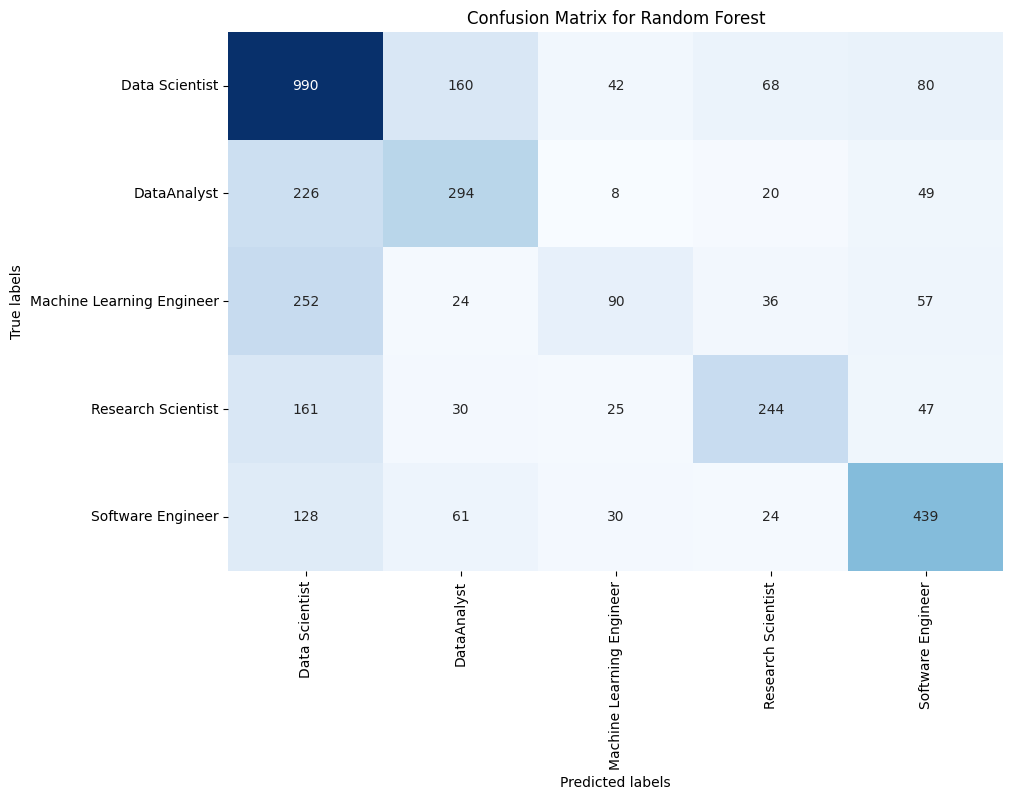

In [286]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
# Convert the encoded labels to actual class names for the axis ticks
axis_labels = [reverse_label_mapping[i] for i in range(len(label_encoder.classes_))]
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=axis_labels, yticklabels=axis_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')

plt.show()

In [287]:
from xgboost import XGBClassifier

# Training an XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_sel, y_train)

# Predicting on the test set
y_pred_xgb = xgb_model.predict(X_test_sel)

# Evaluating the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
#classification_rep_xgb = classification_report(y_test, y_pred_xgb)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Obtaining reverse mapping label
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Using reverse mapping to obtain the class name
y_true_names = [reverse_label_mapping[i] for i in y_test]
y_pred_names = [reverse_label_mapping[i] for i in y_pred_xgb]

# Print evaluation report
report = classification_report(y_true_names, y_pred_names)
print(accuracy_xgb)
print(report)

0.5670850767085077
                           precision    recall  f1-score   support

           Data Scientist       0.59      0.67      0.63      1340
              DataAnalyst       0.48      0.49      0.48       597
Machine Learning Engineer       0.40      0.27      0.32       459
       Research Scientist       0.59      0.53      0.56       507
        Software Engineer       0.65      0.66      0.65       682

                 accuracy                           0.57      3585
                macro avg       0.54      0.52      0.53      3585
             weighted avg       0.56      0.57      0.56      3585



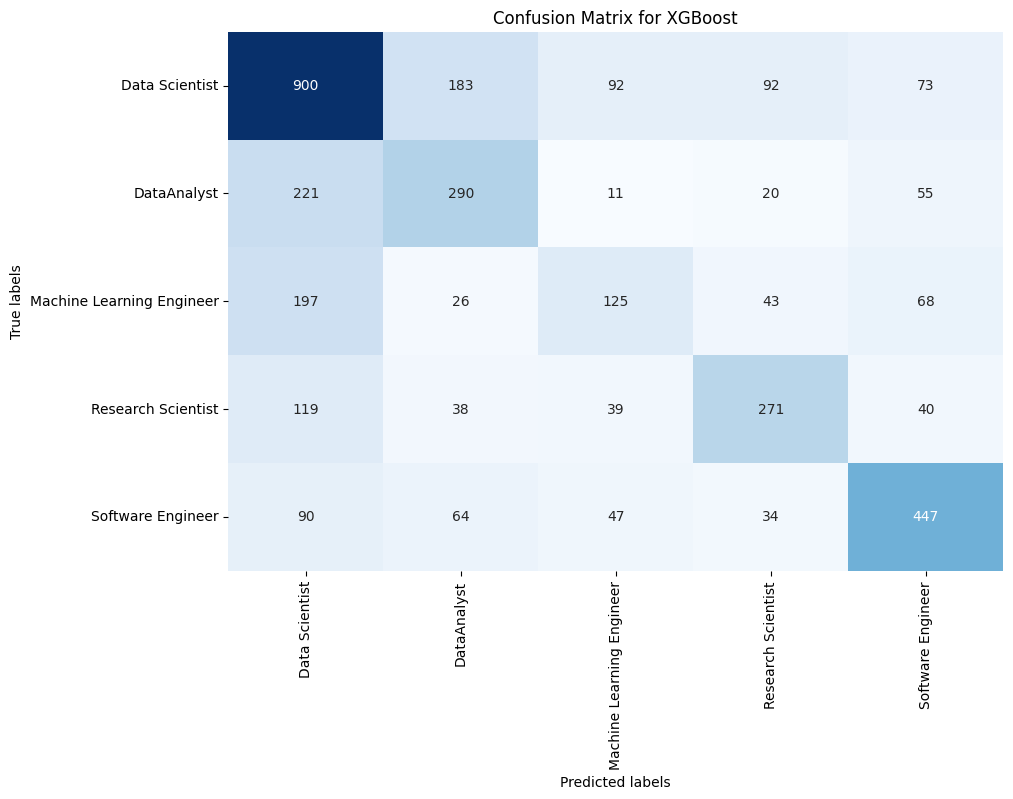

In [288]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(10, 7))
# Convert the encoded labels to actual class names for the axis ticks
axis_labels = [reverse_label_mapping[i] for i in range(len(label_encoder.classes_))]
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=axis_labels, yticklabels=axis_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')

plt.show()

In [289]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train_sel, y_train)

y_pred_gbm = gbm_model.predict(X_test_sel)
accuracy = accuracy_score(y_test, y_pred_gbm)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Obtaining reverse mapping label
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Using reverse mapping to obtain the class name
y_true_names = [reverse_label_mapping[i] for i in y_test]
y_pred_names = [reverse_label_mapping[i] for i in y_pred_gbm]

# Print evaluation report
report = classification_report(y_true_names, y_pred_names)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.5913528591352859
                           precision    recall  f1-score   support

           Data Scientist       0.60      0.71      0.65      1340
              DataAnalyst       0.50      0.53      0.52       597
Machine Learning Engineer       0.48      0.28      0.35       459
       Research Scientist       0.62      0.54      0.58       507
        Software Engineer       0.68      0.67      0.67       682

                 accuracy                           0.59      3585
                macro avg       0.58      0.54      0.55      3585
             weighted avg       0.59      0.59      0.58      3585



Text(0.5, 1.0, 'GBM Report')

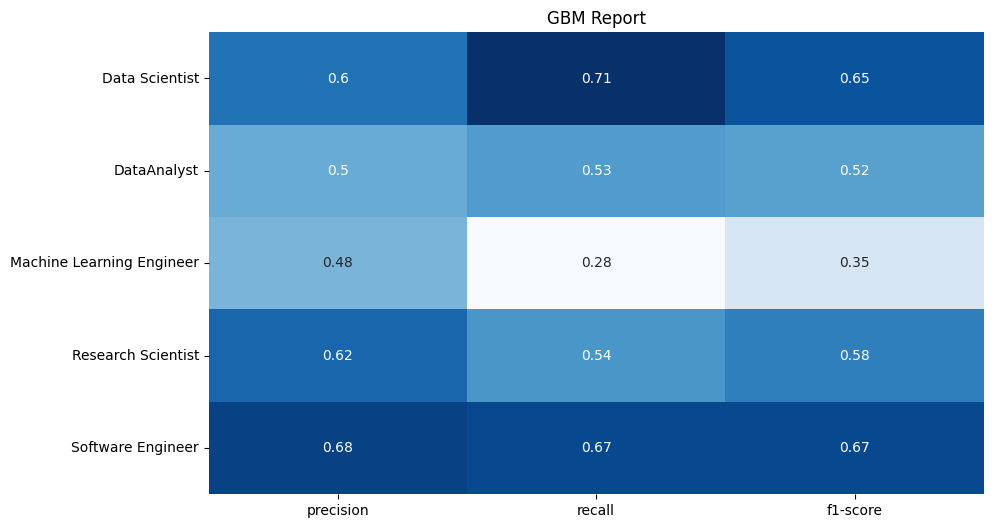

In [290]:
# Convert the report dictionary to a DataFrame
report = classification_report(y_true_names, y_pred_names, output_dict=True)


# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Drop the last three rows: 'accuracy', 'macro avg', 'weighted avg'
report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])

# Round off the values
report_df = report_df.round(2)

# Exclude 'support' column if present
if 'support' in report_df.columns:
    report_df = report_df.drop(columns='support')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap='Blues', cbar=False, fmt='g')
plt.title('GBM Report')

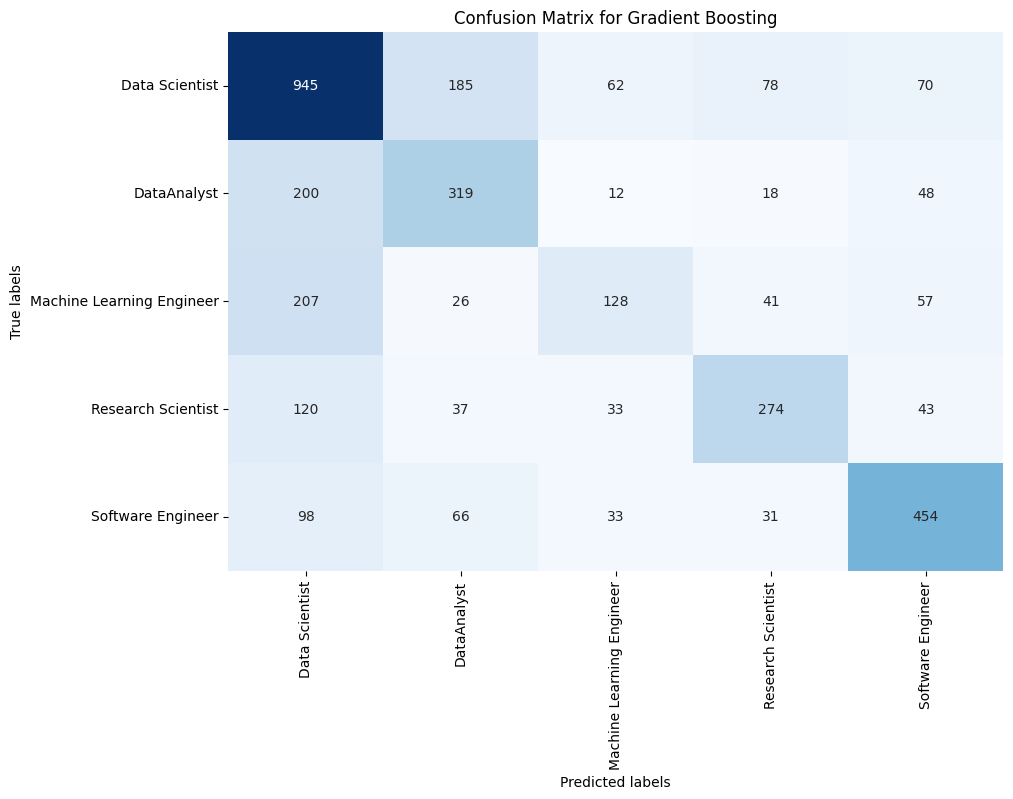

In [291]:
conf_matrix = confusion_matrix(y_test, y_pred_gbm)

plt.figure(figsize=(10, 7))
# Convert the encoded labels to actual class names for the axis ticks
axis_labels = [reverse_label_mapping[i] for i in range(len(label_encoder.classes_))]
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=axis_labels, yticklabels=axis_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Gradient Boosting')

plt.show()

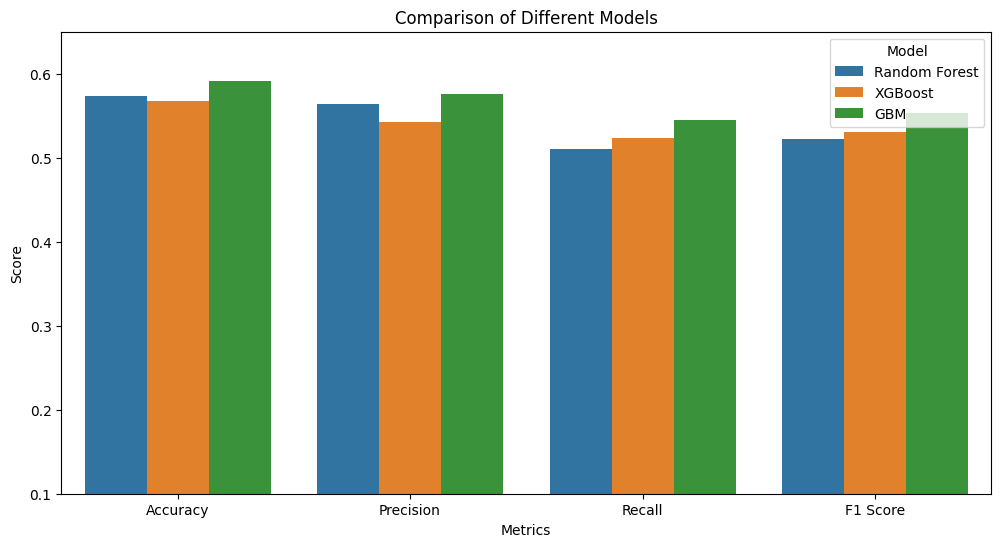

In [292]:
from sklearn.metrics import precision_score, recall_score, f1_score
# 创建一个空的DataFrame来存储结果
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Calculate metrics for each model
for model_name, y_pred in [('Random Forest', y_pred_rf), ('XGBoost', y_pred_xgb), ('GBM', y_pred_gbm)]:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Adding result to a DataFrame
    result_row = pd.DataFrame({'Model': [model_name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1]})
    results = pd.concat([results, result_row], ignore_index=True)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
tidy = results.melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Variable', y='Value', hue='Model', data=tidy)
plt.ylim(0.1, 0.65)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of Different Models')
plt.legend(title='Model')
plt.show()

In [293]:
def highlight_max(s):
    '''
    Highlight the maximum value in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Use style function to highlight
styled_results = results.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# show styled DataFrame
styled_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.573780,0.563484,0.510461,0.522024
1,XGBoost,0.567085,0.542721,0.523935,0.530166
2,GBM,0.591353,0.575795,0.544910,0.553674


In [294]:
# from sklearn.model_selection import GridSearchCV
# # Parameters to tune
# param_grid = {
#     'n_estimators': [50, 100, 150],  # Number of trees in the forest
#     'max_depth': [10, 20, None],  # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
# }

# # Creating the Grid Search model
# grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
#                            param_grid=param_grid,
#                            cv=3,  # 3-fold cross-validation
#                            n_jobs=-1,  # Use all processors
#                            verbose=2)

# # Fitting the Grid Search to the data
# grid_search.fit(X_train, y_train)

# # Best parameters found by Grid Search
# best_params = grid_search.best_params_
# best_params

In [295]:
counts_of_ones = {col: (data[col] == 1).sum() for col in data.columns}
counts_of_ones

{'Age': 68,
 'Job': 3143,
 'Years_of_programming': 1976,
 'Years_of_machine_learning': 229,
 'Company_size': 3718,
 'Yearly_compensation': 35,
 'Bachelor’s degree': 4993,
 'Doctoral degree': 3357,
 'Master’s degree': 8257,
 'No formal education past high school': 216,
 'Professional degree': 215,
 'Professional doctorate': 299,
 'Some college/university study without earning a bachelor’s degree': 587,
 'Bash': 2588,
 'C': 2433,
 'C#': 298,
 'C++': 3175,
 'Go': 84,
 'Java': 3097,
 'Javascript': 3231,
 'Julia': 340,
 'MATLAB': 2040,
 'None': 25,
 'PHP': 191,
 'Python': 16473,
 'R': 4568,
 'SQL': 9179,
 'Swift': 170,
 'IntelliJ': 333,
 'Jupyter': 13471,
 'Notepad++': 3447,
 'PyCharm': 5728,
 'RStudio': 3907,
 'Spyder': 3070,
 'Sublime Text': 2334,
 'Vim / Emacs': 2016,
 'Visual Studio': 2869,
 'Visual Studio Code': 7542,
 'Cloud-certification programs': 1727,
 'Coursera': 9973,
 'DataCamp': 4051,
 'Fast.ai': 1562,
 'Kaggle Learn Courses': 6686,
 'LinkedIn Learning': 2447,
 'Udacity': 3069

In [296]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17924 entries, 0 to 17923
Data columns (total 67 columns):
 #   Column                                                                                           Non-Null Count  Dtype  
---  ------                                                                                           --------------  -----  
 0   Age                                                                                              17924 non-null  float64
 1   Job                                                                                              17924 non-null  int64  
 2   Years_of_programming                                                                             17924 non-null  float64
 3   Years_of_machine_learning                                                                        17924 non-null  float64
 4   Company_size                                                                                     17924 non-null  float64
 5   Year

In [297]:
data.head()

,Age,Job,Years_of_programming,Years_of_machine_learning,Company_size,Yearly_compensation,Bachelor’s degree,Doctoral degree,Master’s degree,No formal education past high school,...,Linear or Logistic Regression,Recurrent Neural Networks,Transformer Networks,Analyze and understand data to influence product or business decisions,Build and/or run a machine learning service that operationally improves my product or workflows,Build and/or run the data infrastructure that my business uses for storing,Build prototypes to explore applying machine learning to new areas,Do research that advances the state of the art of machine learning,Experimentation and iteration to improve existing ML models,None of these activities are an important part of my role at work
0,0.254902,0,0.315789,0.105263,0.060144,0.137069,0,0,1,0,...,1,0,0,1,1,0,0,0,1,0
1,0.352941,0,0.315789,0.052632,0.548817,0.074537,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
2,0.352941,3,0.000000,0.000000,0.000000,0.034517,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
3,0.254902,0,0.000000,0.000000,0.012530,0.000000,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,0.647059,4,1.000000,0.000000,0.012530,0.174587,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
